<a href="https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic4/4.2_dissecting_an_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon.

# 4.2. Dissecting an LLM

In this notebook, we'll study what's inside two LLMs:

* a small [**Qwen2.5-3B-Instruct**](https://huggingface.co/Qwen/Qwen2.5-3B-Instruct). To work with it, you'll need a GPU (L40s will be sufficient).
* a Mixture-of-Expert [**Qwen3-30B-A3B**](https://huggingface.co/Qwen/Qwen3-30B-A3B). To work with it, you'll need at least A100. This part also illustrates LLM parameter counting (and you don't need to load the model for this).

We'll also study **Pytorch hooks** - a built-in tool for inspecting and manipulating transformer internals.

# Part 1. What's inside a decoder-only transformer: a look under the hood of Qwen2.5-3B-Instruct

First of all, let's load the model:

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Let's check what we have inside:

In [ ]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((2048,), eps=1e-06)
    (rotary_emb):

From the look of it, there are:

* 151936 tokens, each encoded as a vector of dimension 2048 (the **hidden dimension of the transformer**)
* 36 transformer layers.

  * The keys (input multiplied by `k_proj`) and the values (input multiplies by `v_proj`) have dimension of 256. This means that we have $2048 / 256 = 8$ query attention heads per each key and value attention head - which clearly signifies that **grouped-query attention** is used.

  <center>
  <img src="https://drive.google.com/uc?export=view&id=1uRBpGed0DboHXU9SEq5obWgrpEgBVgPf" width=800 />

  [Source](https://arxiv.org/pdf/2305.13245)
  </center>
  
  * The FFN block has hidden dimension 11008, which is quite big. Having large internal states in FFN is typical for many transformers. It is claimed by some authors that FFN layers serve as the LLM's "memory storage".

  * In contrast with many other transformer models, Qwen has two LayerNorm layers in each of the transformer blocks - before and after attention.

  * Note that all linear layers in the FFN part have no bias terms (that is, they are $x\mapsto xW + w_0$ with $w_0 = 0$). This is quite conventional for LLMs. Moreover, you'll often see no-bias linear layers in the attention mechanism.

Some things, however, can't be inferred from just looking at what's inside the model, for example:

* What is the exact FFN architecture
* How many attention heads are there
* How is the attention mask applied
* etc

Let's continue our journey by looking at the model config:

In [ ]:
model.config

Qwen2Config {
  "_attn_implementation_autoset": true,
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 32768,
  "max_window_layers": 70,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 36,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}

Here's some of the new information we get from here:

* The number of attention heads is 16
* RoPE base (`rope_theta`) is 1000000, which means that

  $\theta_i = 1000000^{-2(i-1)/d}$

  This base is larger than the original 10000, likely an adaptation for larger context lengths.

* The model type is `"qwen2"`. In practice, it means that the code for Qwen-2.5-3B is to be found in qwen2-related repos. For example, at huggingface it will be [https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2/](https://github.com/huggingface/transformers/blob/main/src/transformers/models/qwen2/).

  Let's look at the code, because it will reveal some more information about the model's internals.

  (Actually, we could also understand this by looking at the class name `Qwen2ForCausalLM`.)

## Qwen2MLP

The FFN architecture becomes clear after looking at the `Qwen2MLP` class:

```python
class Qwen2MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.act_fn = ACT2FN[config.hidden_act]

    def forward(self, x):
        down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
        return down_proj
```

As you see, we have a gating mechanism here

It's not perfectly clear from this code which the activation function `act_fn` is, so let's take a look at an individual layer instance to discover that it's $\mathrm{SiLU}(x) = x \cdot \sigma(x)$.

In [ ]:
model.model.layers[0].mlp

Qwen2MLP(
  (gate_proj): Linear(in_features=2048, out_features=11008, bias=False)
  (up_proj): Linear(in_features=2048, out_features=11008, bias=False)
  (down_proj): Linear(in_features=11008, out_features=2048, bias=False)
  (act_fn): SiLU()
)

Thus the MLP architecture is as follows:

<center>
<img src="https://drive.google.com/uc?export=view&id=1rQqwrZtKBUvhFbc08d4Z2eDHkh8RM0UY" width=600 />
</center>


## Qwen2Attention

Its implementation doesn't tell us much, referring to `self.config._attn_implementation` and `ALL_ATTENTION_FUNCTIONS`. That's because, indeed, different implementations of attention might be used - one of the most prominent of them being **FlashAttention**.

```python
class Qwen2Attention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config: Qwen2Config, layer_idx: int):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx
        self.head_dim = getattr(config, "head_dim", config.hidden_size // config.num_attention_heads)
        self.num_key_value_groups = config.num_attention_heads // config.num_key_value_heads
        self.scaling = self.head_dim**-0.5
        self.attention_dropout = config.attention_dropout
        self.is_causal = True
        self.q_proj = nn.Linear(config.hidden_size, config.num_attention_heads * self.head_dim, bias=True)
        self.k_proj = nn.Linear(config.hidden_size, config.num_key_value_heads * self.head_dim, bias=True)
        self.v_proj = nn.Linear(config.hidden_size, config.num_key_value_heads * self.head_dim, bias=True)
        self.o_proj = nn.Linear(config.num_attention_heads * self.head_dim, config.hidden_size, bias=False)

    def forward(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: Tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_value: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs: Unpack[FlashAttentionKwargs],
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if past_key_value is not None:
            # sin and cos are specific to RoPE models; cache_position needed for the static cache
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

        sliding_window = None
        if (
            self.config.use_sliding_window
            and getattr(self.config, "sliding_window", None) is not None
            and self.layer_idx >= self.config.max_window_layers
        ):
            sliding_window = self.config.sliding_window

        attention_interface: Callable = eager_attention_forward
        if self.config._attn_implementation != "eager":
            if self.config._attn_implementation == "sdpa" and kwargs.get("output_attentions", False):
                logger.warning_once(
                    "`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to "
                    'eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.'
                )
            else:
                attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]

        attn_output, attn_weights = attention_interface(
            self,
            query_states,
            key_states,
            value_states,
            attention_mask,
            dropout=0.0 if not self.training else self.attention_dropout,
            scaling=self.scaling,
            sliding_window=sliding_window,  # main diff with Llama
            **kwargs,
        )

        attn_output = attn_output.reshape(*input_shape, -1).contiguous()
        attn_output = self.o_proj(attn_output)
        return attn_output, attn_weights

```

### Scaled dot product attention

Since we haven't turned on any fancy attention implementation, a simple **Scaled dot product attention** is used.

In [ ]:
model.config._attn_implementation

'sdpa'

It is implemented in Torch. The code itself is in C++, but we can check a reference Python translation in the Torch's `functional.py` file. (It's a docstring, not an actual implementation; the actual implementation is in a different place and in C++.)

```python
scaled_dot_product_attention = _add_docstr(
    torch._C._nn.scaled_dot_product_attention,
    r"""scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0,
        is_causal=False, scale=None, enable_gqa=False) -> Tensor:

    Computes scaled dot product attention on query, key and value tensors, using an optional attention mask if passed,
    and applying dropout if a probability greater than 0.0 is specified. The optional scale argument can only be
    specified as a keyword argument.

    .. code-block:: python

        # Efficient implementation equivalent to the following:
        def scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0,
                is_causal=False, scale=None, enable_gqa=False) -> torch.Tensor:
            L, S = query.size(-2), key.size(-2)
            scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
            attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)
            if is_causal:
                assert attn_mask is None
                temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
                attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
                attn_bias.to(query.dtype)

            if attn_mask is not None:
                if attn_mask.dtype == torch.bool:
                    attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
                else:
                    attn_bias = attn_mask + attn_bias

            if enable_gqa:
                key = key.repeat_interleave(query.size(-3)//key.size(-3), -3)
                value = value.repeat_interleave(query.size(-3)//value.size(-3), -3)

            attn_weight = query @ key.transpose(-2, -1) * scale_factor
            attn_weight += attn_bias
            attn_weight = torch.softmax(attn_weight, dim=-1)
            attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
            return attn_weight @ value

```

It shows several attention features:

* The **attention mask** is *additive* `attn_weight += attn_bias`, with `-inf` at positions corresponding to the attention weights we want to disregard.

  The code

  ```python
  attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)
  temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
  attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
  ```

  produces a matrix with zeros on the main diagonal and below and with `-inf` above the diagonal.

  The elements $a_{ij}$ which are above the diagonal ($i < j$) correspond to attention weights coming from $q_ik_j^T$ where qn *earlier* query "attends" to a *later* key. Since we **don't look into the future**, we get rid of such attention weights.

In [ ]:
L, S = 5, 5
attn_bias = torch.zeros(L, S)
temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
attn_bias

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

Further parts of the code are as expected:

```python
           if enable_gqa:
                key = key.repeat_interleave(query.size(-3)//key.size(-3), -3)
                value = value.repeat_interleave(query.size(-3)//value.size(-3), -3)
            
            # A = QK^T / sqrt{d}
            attn_weight = query @ key.transpose(-2, -1) * scale_factor
            # Adding the mask
            attn_weight += attn_bias
            # Softmax
            attn_weight = torch.softmax(attn_weight, dim=-1)
            # Optional dropout
            attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
            # Mutliplying by values
            return attn_weight @ value
```

The first `if` works for **Grouped-Query Attention**. It repeats each KV head g times along the head axis (-3), where

$$g = \frac{\mbox{number of KV heads}}{\mbox{number of Q heads​}}$$

This allows to align KV-heads with the corresponding Query heads.

<center>
<img src="https://drive.google.com/uc?export=view&id=11LAJZAriQBa32BQ4HsiNKycEDZJaotOY" width=600 />
</center>

# Part 2. Pytorch hooks

Pytorch provides a built-in way to inspect or modify layer's computation - **Hooks**. A hook is a function that you can *register* on a layer; it is then automatically called each time that layer runs. More accurately:

* **Forward hooks** trigger during the forward pass, immediately after the layer produces its output.

  The hook's interface might look like `ablate_head(module, inp, out, head_idx)`. Here,

  * `module` is the module (layer) on which the hook is registered
  * `inp` is the layer's input
  * `out` is the layer's output

  These are three required arguments; you can add custom arguments if you want - in our case it's `head_idx`.

  This forward hook may be registered on a layer `layer` as follows:

  `handle = layer.register_forward_hook(partial(ablate_head, head_idx=2))`

  With `partial`, we only need to show custom arguments here.

* **Backward hooks** are registered on *tensors*, that is on particular weight matrices. They trigger during backpropagation, as gradients flow through the tensor.

  A backward hook is a function of *gradient*, like `grad_clipper(grad)`

Several potential use cases of hooks include:

1. **Gradient manipulations during backward pass**. For example, **gradient clipping** for a particular layer might be set up in the following way:

```python
def grad_clipper(grad):
    # Clip gradient to [-1, 1]
    return grad.clamp(-1, 1)

layer = # ... some layer
weight_to_clip = layer.weight
# Retistering a backward hook
clipping_hook = weight_to_clip.register_hook(grad_clipper)

loss.backward()

# A hook is to be removed after usage
clipping_hook.remove()
```

2. **Intervention during forward pass**. For example, this is how you can mask one of the attention heads for **attention-head ablation** ([this paper](https://arxiv.org/pdf/1905.10650) served as an inspiration).

```python
def ablate_head(module, inp, out, head_idx):
    """
    Zeros out head number head_idx in the transformer block number layer_idx.
    Attention head is a slice in of q_proj, k_proj and v_proj matrices.
    So, we need to locate this slice as start:end

    module: the attention module
    out: tensor of shape [batch, seq_len, embed_dim]
    """
    # Locate the slice
    num_heads = module.num_heads
    head_dim  = out.size(-1) // num_heads
    start = head_idx * head_dim
    end = (head_idx + 1) * head_dim

    # Zero out that head's slice
    out[:, :, start:end] = 0
    return out

layer = model.model.layers[0].self_attn.q_proj
handle = layer.register_forward_hook(
    partial(ablate_head, head_idx=2)
)

with torch.no_grad():
    result = model(**inputs)

# The hook must be removed after use
handle.remove()
```

3. **Communication hooks** that can be used to establish custom information exchange between GPU workers in a distributed training or inference scenario, see [Pytorch docs](https://docs.pytorch.org/docs/stable/ddp_comm_hooks.html).

**WARNING!** If your hook crashes before it can return anything, `hook.remove()` won't remove the failed hook - it will stay, and it won't change when you try to register its rewritten version. In this case you'll observe a maddening picture: if you rewrite the hook and run the code again, it will crash again, and you'll see your old code in the error message.

To get rid of failing hook, you'll need to run

```python
layer._forward_hooks.clear()
```

for a forward hook, or

```python
layer._forward_pre_hooks.clear()
```

for backward hooks or forward pre-hooks.

To check which forward hooks are running on a layer, use

```python
layer._forward_hooks.keys()
```

**Note**. While you can get your hands on transformer activations without hooks (we'll do it shortly), hooks truly shine when you need to intervene and change something during generation. And this, you'll try in the practice part!

## Studying attention heads of Qwen 2.5

In this subsection, we'll investigate some of the attention heads of **Qwen2.5-3B-Instruct** based on how informative they are.

Let's clarify what we mean by informativity. For each token, a self-attention head calculates attention scores, which, after softmax, are used to calculate the output

$$a_{n0}v_0 + a_{n1}v_1 + \ldots + a_{n, n-1}v_{n-1} + a_{nn}v_n,$$

where $v_i$ are the value vectors. Thanks to the softmax, $a_{nj}$ make up a *probability distribution*:

* $0 \leqslant a_{nj} \leqslant 1$
* $\sum_{j=0}^na_{nj} = 1$

These distributions may be quite different:

* If, for all sequences, $a_{n0} = 1$ (all the attention is to the `<BOS>` token) or $a_{nn} = 1$ (all the attention is to the current token) and other $a_{nj}$ are zero, this head doesn't contribute much to the generation process. It is *not informative*.

  Here's an illustration. On the left picture all the attention is to `<BOS>` and on the right one - to the current token. Each *row* shows the attention scores for the corresponding token.

  <center>
  <img src="https://drive.google.com/uc?export=view&id=1sqjlehXwmDYS-d_YB30uckwvHZxLWA4e" width=800 />
  </center>

* If the attention is scattered uniformly along the sequence (all $a_{nj}$ are roughly the same), this attention head might be useful, but is also *not informative*.

  Here's an illustration of a head that is probably not very informative.

  <center>
  <img src="https://drive.google.com/uc?export=view&id=1pADwyb0Wc0BmgvcC2n1Z4CXYtOLjt5ay" width=500 />
  </center>

  By the way, this picture illustrates the **causal** nature of the attention - it "doesn't look into the future". Indeed, no token (`y` axis) attends to any token after it; mathematically, $a_{nj} = 0$ for $j > n$.

* If there is a clear attention pattern, with $a_{nj}$ being nonzero only for some particular tokens, the attention head might be *informative*.

  Here is an example of a structured attention pattern. Note that, unlike the previous pictures which showed attention of prompt vs prompt, here we see attention scores of competion tokens towards prompt and completion tokens. And here again, no completion tokens looks into the future tokens.

  <center>
  <img src="https://drive.google.com/uc?export=view&id=1yqNrRCkYf9UEDaWK4cd14IKa4ubAotBL" width=500 />
  </center>

But how do we find non-informative heads? We'll do it using [**entropy**](https://en.wikipedia.org/wiki/Entropy_(information_theory)). It is a measure of uncertainty of a probability distribution. In particular, entropy will be:

* Near-zero for attention heads that focus solely on `<BOS>` or the current token
* The highest for attention heads that spread attention uniformly across tokens
* Something in between for truly meaningful heads.

The math formula of entropy, in the case of attention scores, is:

$$-\sum_{j=0}^na_{nj}\log{a_{nj}}$$

Does this sound too theoretical for you? Let's examine real heads of a real LLM!

We'll experiment with the same **Qwen2.5-3B-Instruct** model. Our plan is:

* On each attention layer, register a **hook** that will capture the entropies of every attention head.
* Run the LLM on several prompts to collect attention head entropy statistics.
* Create a histogram of attention head entropies.
* Visualize several heads with the lowest entropy and the highest entropy, as well as several in the middle.

In [ ]:
# Uncomment and run this cell if you haven't loaded the model yet on the current colab run
'''
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="bfloat16",
    device_map="auto",
    trust_remote_code=True
)
'''

We want each self-attention layer to have its personal hook, so we'll create a hook factory:

In [ ]:
import torch
from collections import defaultdict
from functools import partial

entropies_sum = defaultdict(float)   # (layer, head) -> Σ entropy
counts        = defaultdict(int)     # (layer, head) -> # of batches seen

def make_entropy_hook(layer_idx):
    def hook(_m, _inp, out):
        # The output of the attention head is (hidden_states, attention_scores)
        # attention_scores are what we need
        _, p = out                       # p: [batch_size, n_heads, seq_len, seq_len]
        ent = -(p * torch.log(p + 1e-10)).sum(-1)  # [batch_size, n_heads, seq_len]
        # Aggregate across the batch size and the sequence length:
        ent = ent.mean(dim=(0, 2)).squeeze()            # [n_heads]
        for h_idx, e in enumerate(ent):
            entropies_sum[(layer_idx, h_idx)] += e.item()
            counts[(layer_idx, h_idx)]      += 1
    return hook

# Register personal hook for every layer
hook_handles = []
for i, layer in enumerate(model.model.layers):
    h = layer.self_attn.register_forward_hook(make_entropy_hook(i))
    hook_handles.append(h)


Now, let's run inference on several prompts:

In [ ]:
prompts = [
    "Write a haiku about the moon.",
    "Explain quantum entanglement in one sentence.",
    "Translate 'Good morning' to Japanese.",
    "List 5 unique features of the human genome.",
    "Summarize the plot of 'To Kill a Mockingbird.'",
]

for prompt in prompts:
    chat = tokenizer.apply_chat_template(
        [{"role":"user","content":prompt}],
        tokenize=False,
        add_generation_prompt=True
    )
    inputs = tokenizer([chat], return_tensors="pt").to(model.device)
    # We need to set output_attentions=True; otherwise we won't get attention scores in the output
    _ = model(**inputs, output_attentions=True, use_cache=False)

# Remove the hooks; we won't need them any more
for h in hook_handles:
    h.remove()

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Now, let's start analyzing the result. This cell does the following:

* Constructs a histogram of all attention head entropies.
* Chooses all heads with entropy < 0.1; 5 heads with max entropy; and 5 random heads in the middle.

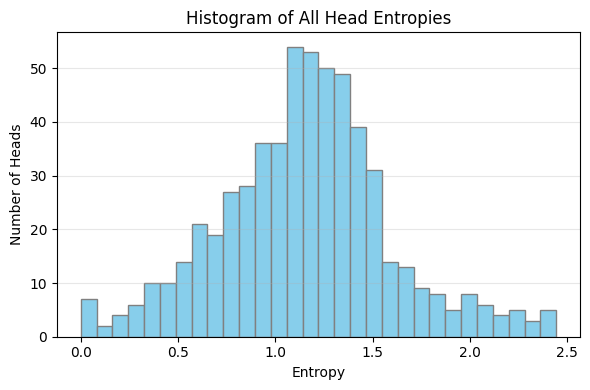


Heads with entropy < 0.1:
  Layer 27, Head 8  →  Entropy = 0.0001
  Layer 5, Head 10  →  Entropy = 0.0004
  Layer 0, Head 12  →  Entropy = 0.0087
  Layer 5, Head 11  →  Entropy = 0.0187
  Layer 20, Head 7  →  Entropy = 0.0347
  Layer 25, Head 1  →  Entropy = 0.0407
  Layer 5, Head 15  →  Entropy = 0.0784
  Layer 17, Head 14  →  Entropy = 0.0836

Top-5 highest-entropy heads:
  Layer 1, Head 6  →  Entropy = 2.4438
  Layer 1, Head 3  →  Entropy = 2.4375
  Layer 2, Head 2  →  Entropy = 2.4344
  Layer 0, Head 15  →  Entropy = 2.4062
  Layer 2, Head 4  →  Entropy = 2.4031

5 random heads with entropy between 1.075 and 1.258:
  Layer 28, Head 4  →  Entropy = 1.2109
  Layer 8, Head 6  →  Entropy = 1.1031
  Layer 3, Head 9  →  Entropy = 1.1641
  Layer 32, Head 2  →  Entropy = 1.1703
  Layer 14, Head 9  →  Entropy = 1.1172


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

avg_entropy = {
    key: entropies_sum[key] / counts[key]
    for key in entropies_sum
}


ent_values = np.array(list(avg_entropy.values()))

plt.figure(figsize=(6,4))
plt.hist(ent_values, bins=30, color='skyblue', edgecolor='gray')
plt.title("Histogram of All Head Entropies")
plt.xlabel("Entropy"); plt.ylabel("Number of Heads")
plt.grid(axis='y', alpha=0.3); plt.tight_layout(); plt.show()

# (a) heads with entropy < 0.1
threshold = 0.1
low_heads = [(l,h,e) for (l,h),e in avg_entropy.items() if e < threshold]
print(f"\nHeads with entropy < {threshold}:")
if not low_heads:
    print("  (none found)")
else:
    for l,h,e in sorted(low_heads, key=lambda x:(x[2],x[0],x[1])):
        print(f"  Layer {l}, Head {h}  →  Entropy = {e:.4f}")

# (b) 5 highest-entropy heads
top5 = sorted(avg_entropy.items(), key=lambda x:x[1], reverse=True)[:5]
print("\nTop-5 highest-entropy heads:")
for (l,h),e in top5:
    print(f"  Layer {l}, Head {h}  →  Entropy = {e:.4f}")

# (c) 5 random heads from the 40–60 % band
low_pct, high_pct = np.percentile(ent_values, [40,60])
mid_candidates = [(l,h,e) for (l,h),e in avg_entropy.items()
                  if low_pct <= e <= high_pct]
random.seed(42)
mid_sample = random.sample(mid_candidates, k=min(5,len(mid_candidates)))
print(f"\n5 random heads with entropy between {low_pct:.3f} and {high_pct:.3f}:")
for l,h,e in mid_sample:
    print(f"  Layer {l}, Head {h}  →  Entropy = {e:.4f}")

As you see, entropies are almost gaussian, though there is a surprisingly large number of low-entropy heads.

Now, let's visualize the attention patterns for some given probe prompt. You can choose a different prompt and check if the patterns stay the same.

Getting attention scores is actually quite simple even without hooks. If you run

```python
outputs = model(**inputs, output_attentions=True, use_cache=False)
```

with `output_attentions=True`, you can get attentions for all layers with `attn_tensors = outputs.attentions`.


Will visualise 18 heads.


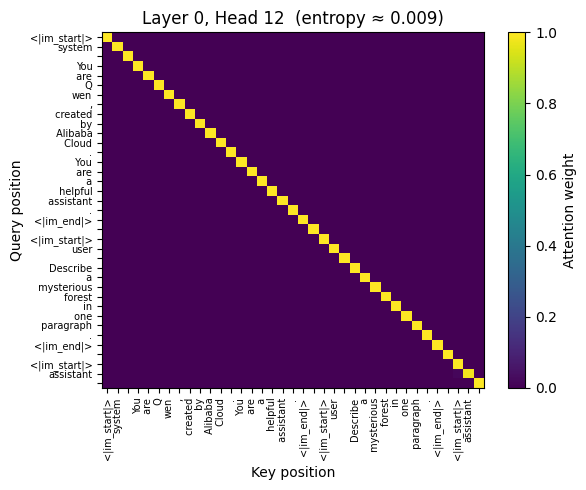

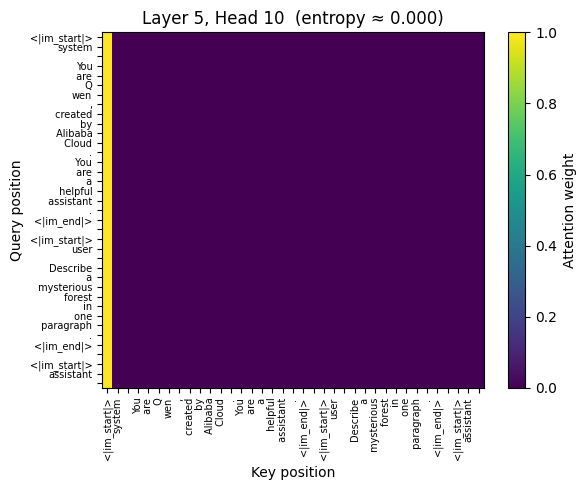

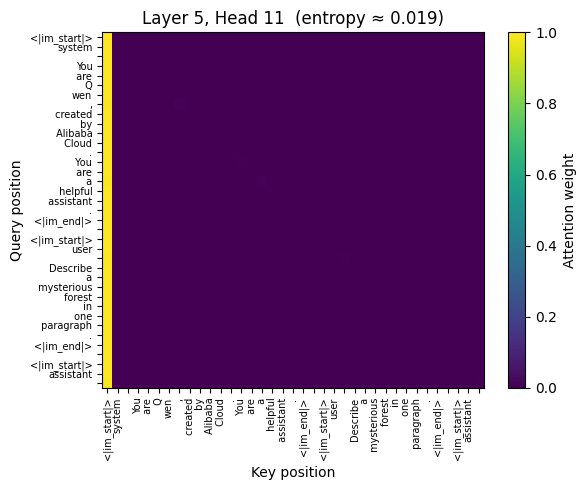

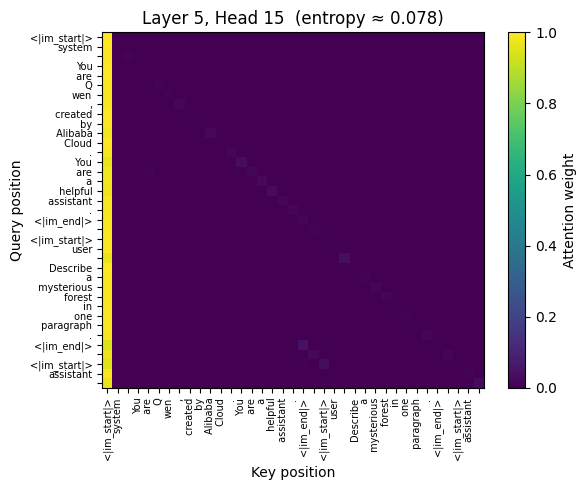

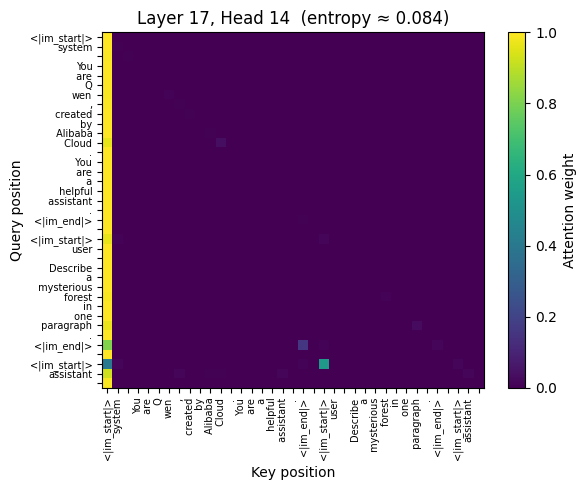

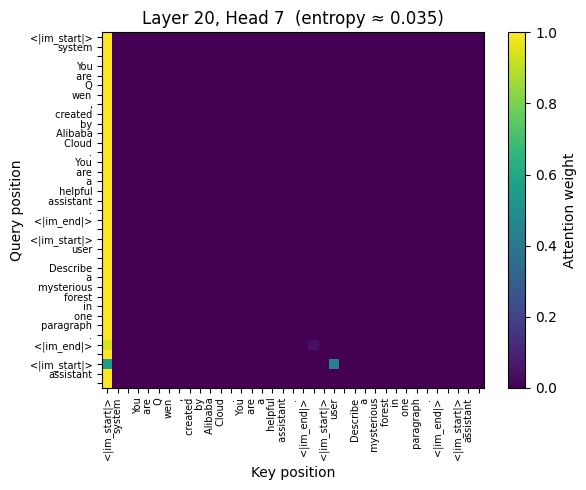

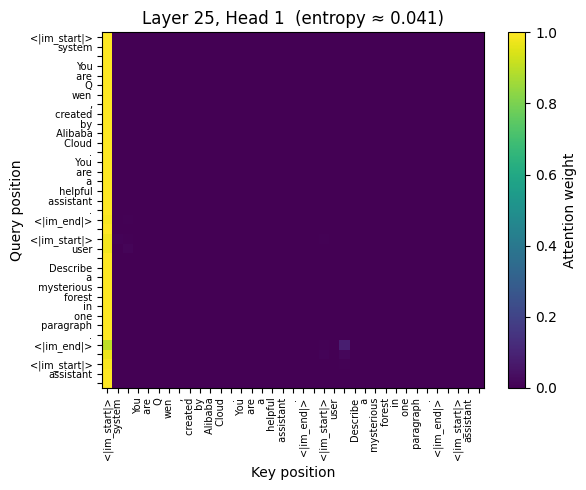

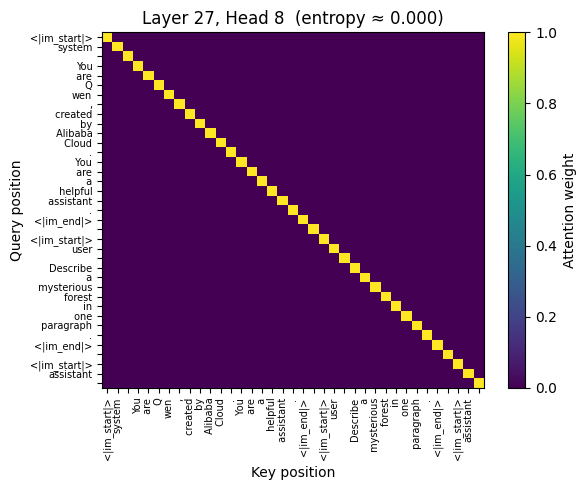

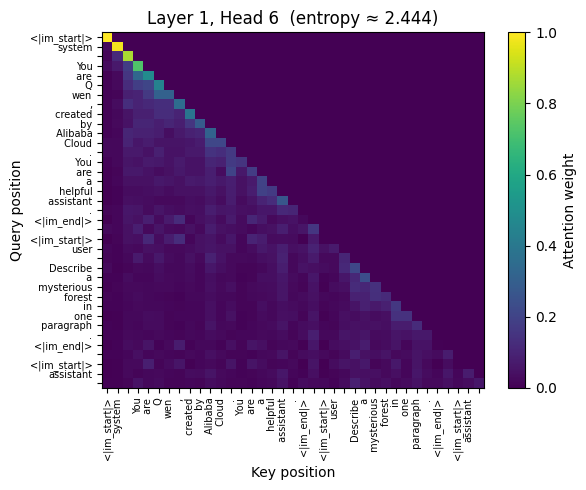

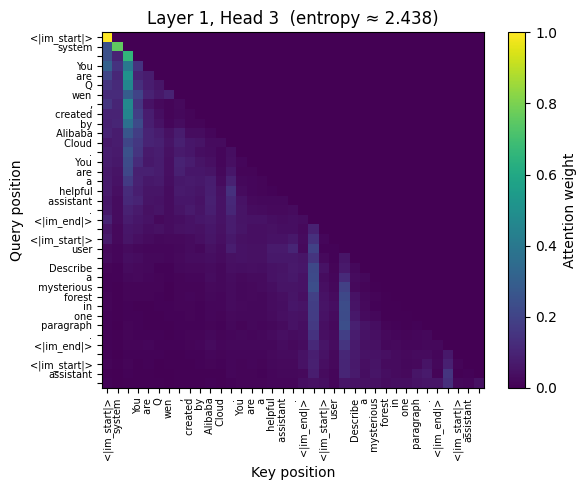

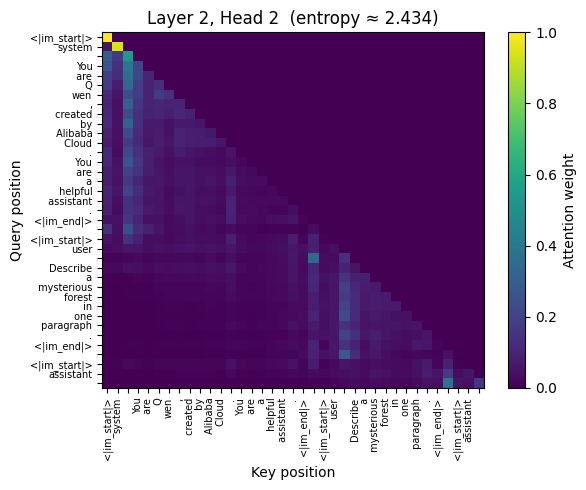

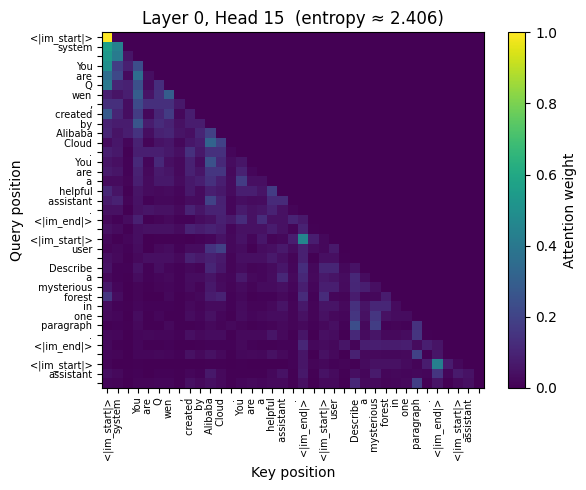

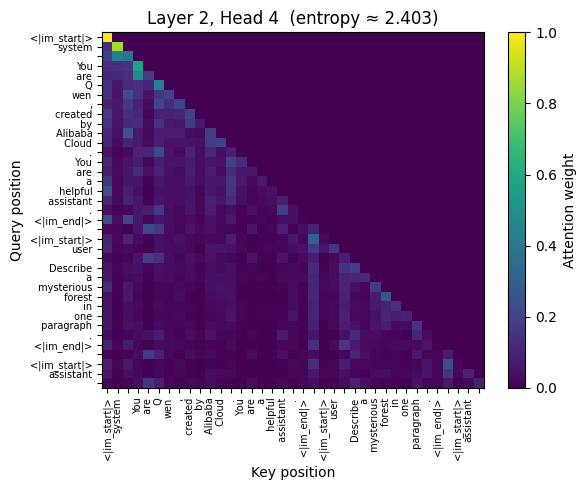

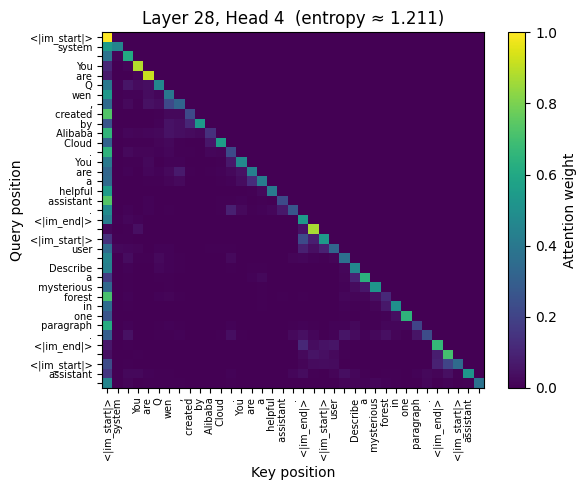

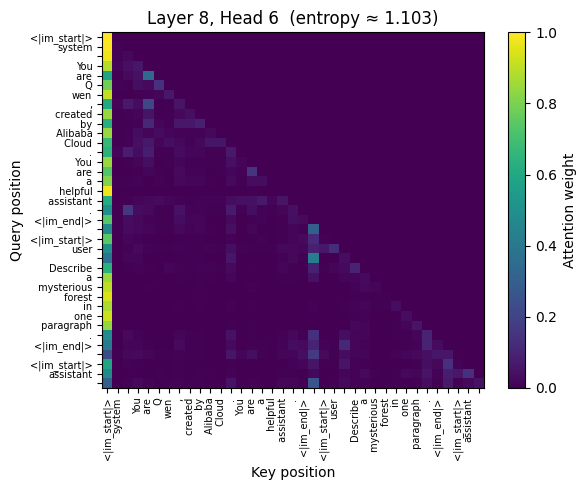

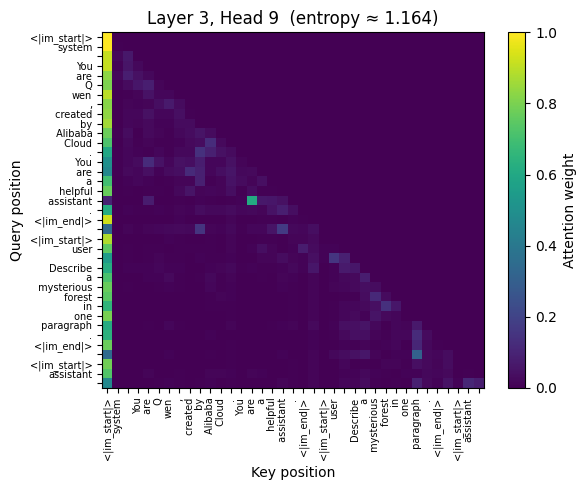

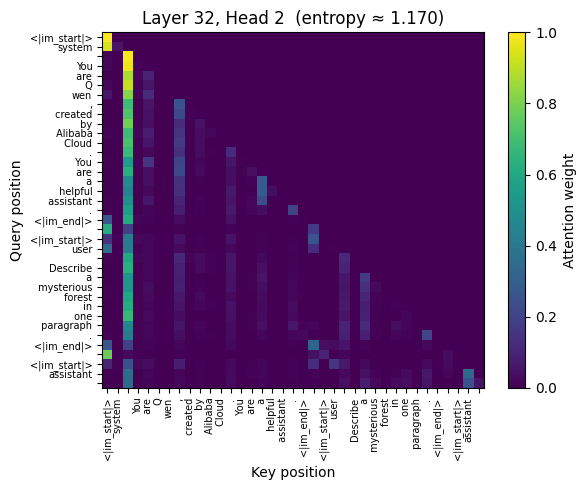

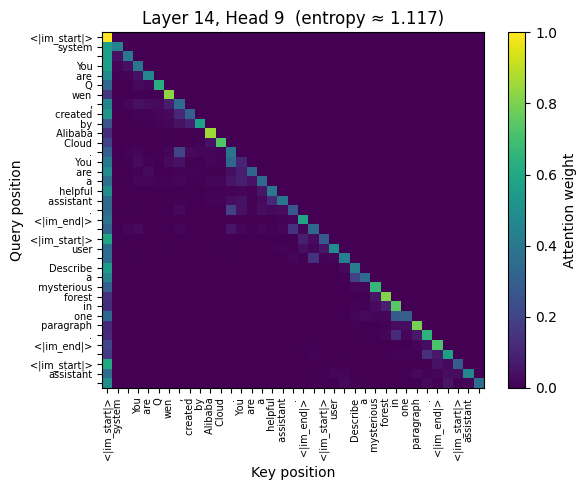

In [ ]:
import torch
import matplotlib.pyplot as plt

probe_prompt = "Describe a mysterious forest in one paragraph."  # any sentence you like

heads_to_plot = {}
for l, h, e in low_heads:
    heads_to_plot[(l, h)] = e
for (l, h), e in top5:
    heads_to_plot[(l, h)] = e
for l, h, e in mid_sample:
    heads_to_plot[(l, h)] = e

selected_heads = list(heads_to_plot.items())
print(f"\nWill visualise {len(selected_heads)} heads.")

# Run a forward pass with the probe prompt and caprute attention scores
chat = tokenizer.apply_chat_template(
    [{"role": "user", "content": probe_prompt}],
    tokenize=False, add_generation_prompt=True
)
inputs  = tokenizer([chat], return_tensors="pt").to(model.device)
outputs = model(**inputs, output_attentions=True, use_cache=False)

attn_tensors = outputs.attentions          # tuple of length = num_layers
token_ids    = inputs.input_ids[0]
tokens_str   = [tokenizer.decode([tid]) for tid in token_ids]

# Visualization
for (layer_idx, head_idx), ent_val in selected_heads:
    attn_mat = attn_tensors[layer_idx][0, head_idx].to(torch.float32).cpu().detach().numpy()  # [T, T]
    T = attn_mat.shape[0]

    plt.figure(figsize=(6, 5))
    plt.imshow(attn_mat[::-1,:], cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Attention weight')
    plt.title(f"Layer {layer_idx}, Head {head_idx}  (entropy ≈ {ent_val:.3f})")
    plt.xlabel("Key position")
    plt.ylabel("Query position")

    if T <= 40:
        plt.xticks(range(T), tokens_str, rotation=90, fontsize=7)
        plt.yticks(range(T), tokens_str[::-1], rotation=0,  fontsize=7)
    else:
        plt.xticks([]); plt.yticks([])

    plt.tight_layout()
    plt.show()


Now, let's look at the attention scores of completion tokens with respect to prompt and completion tokens:

Selected 18 heads for visualization

Prompt length = 39, Generated length = 20, Total = 59


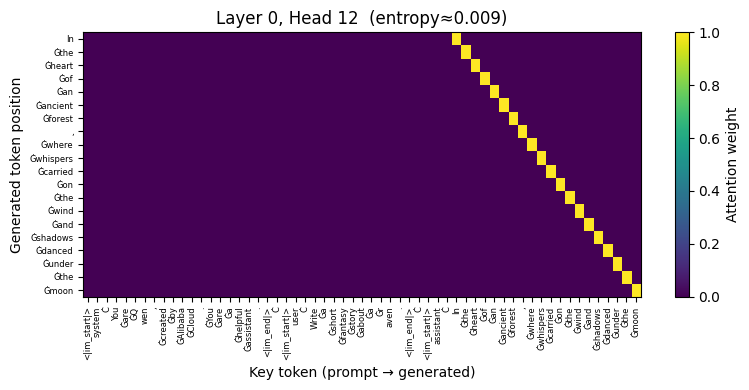

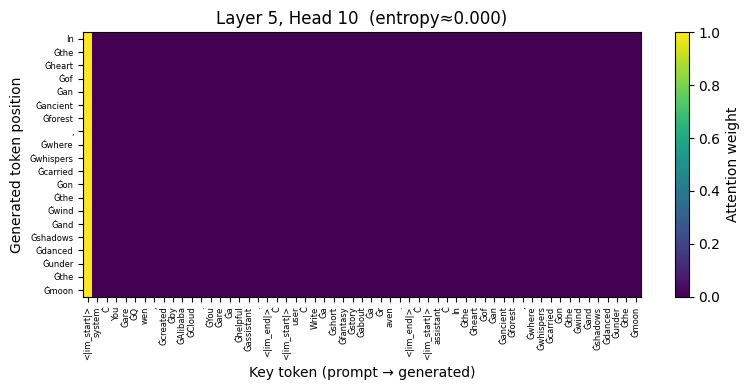

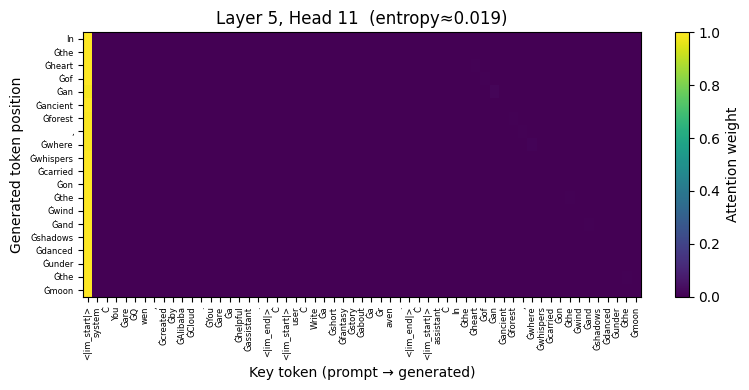

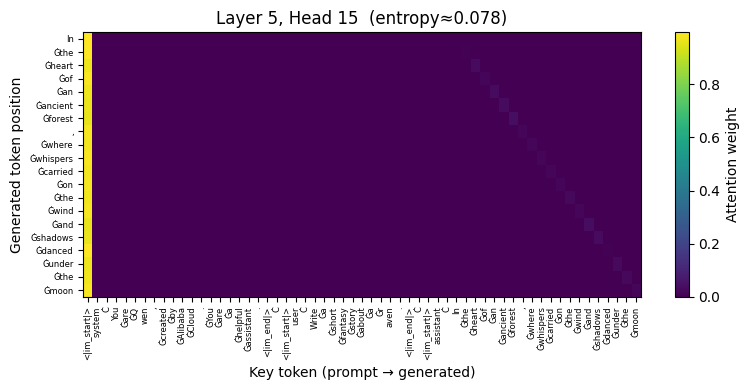

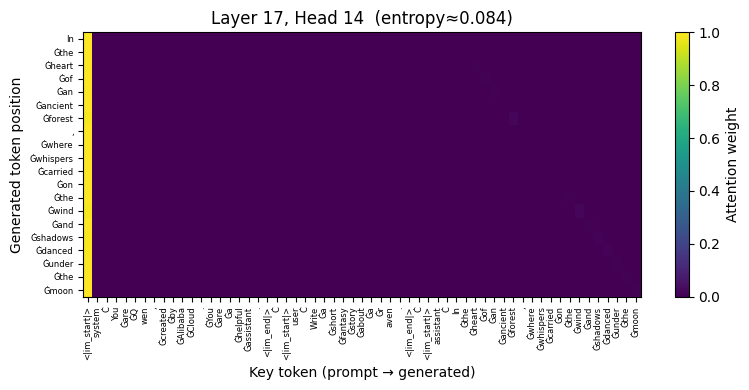

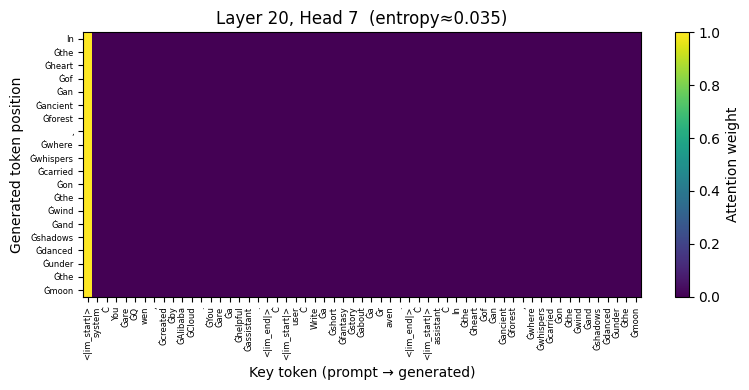

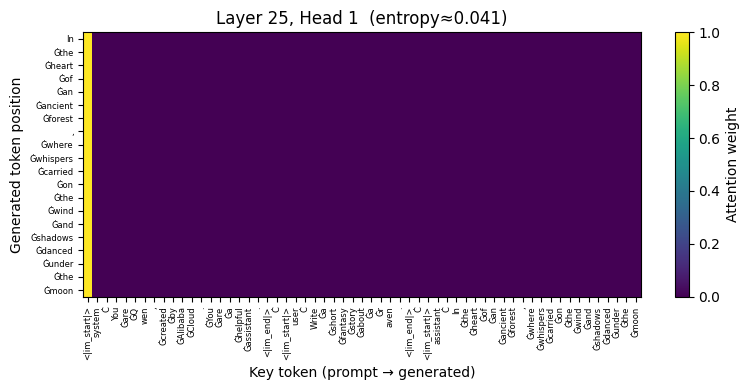

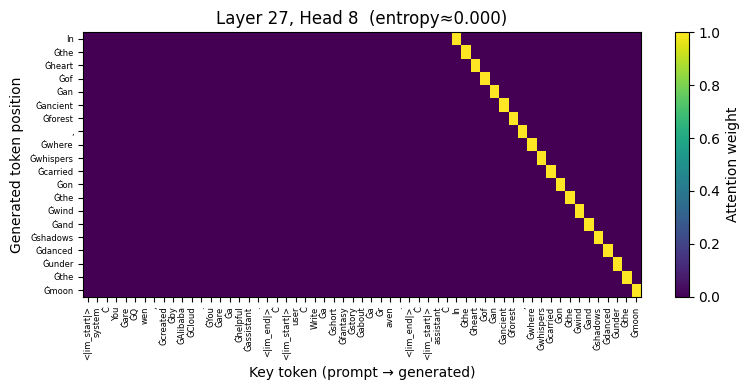

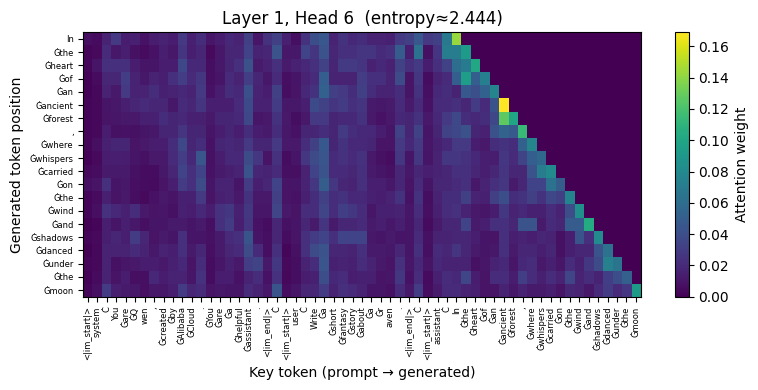

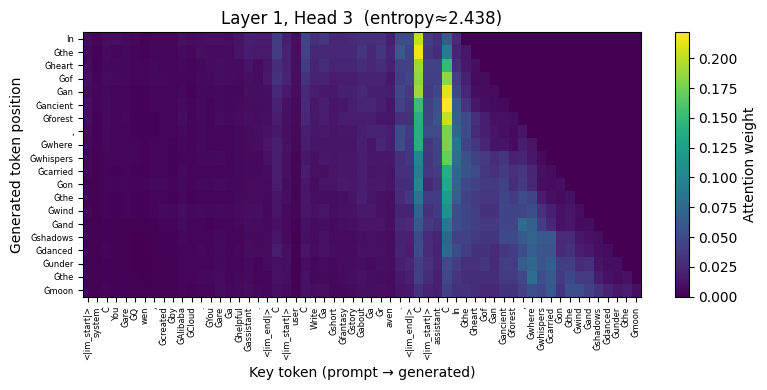

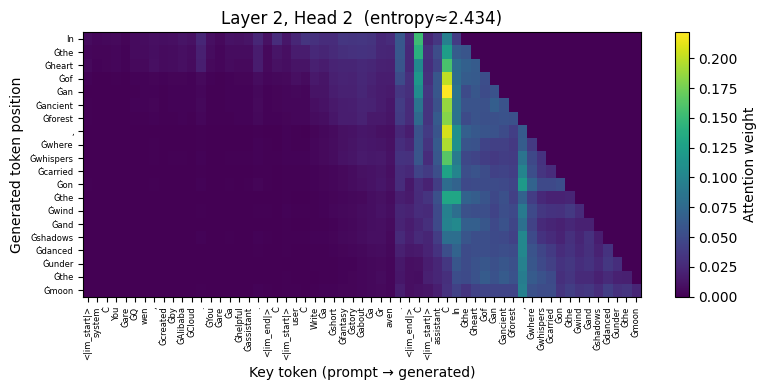

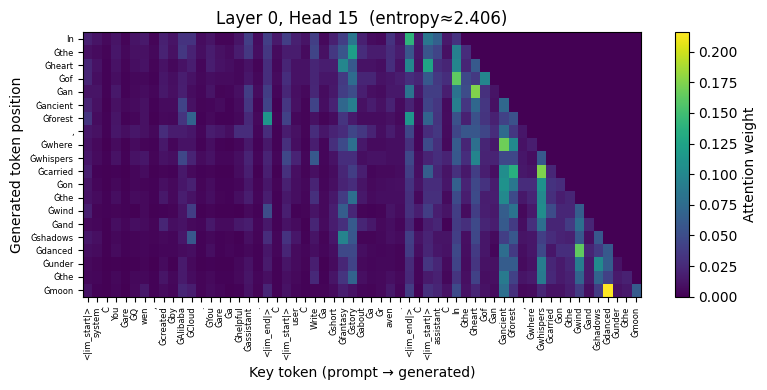

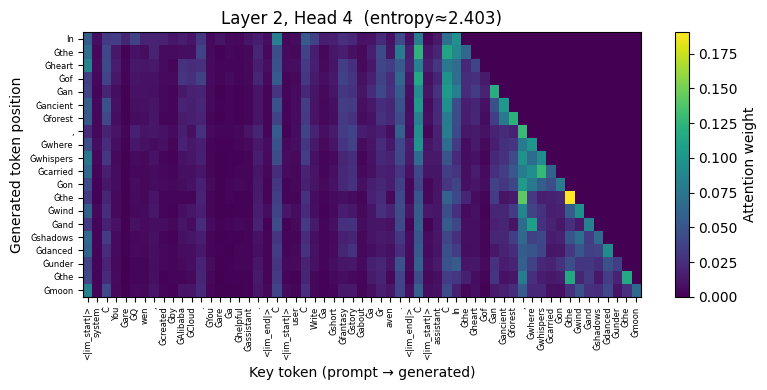

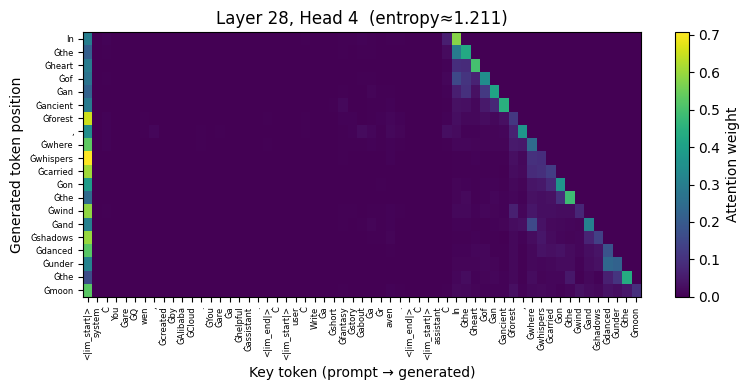

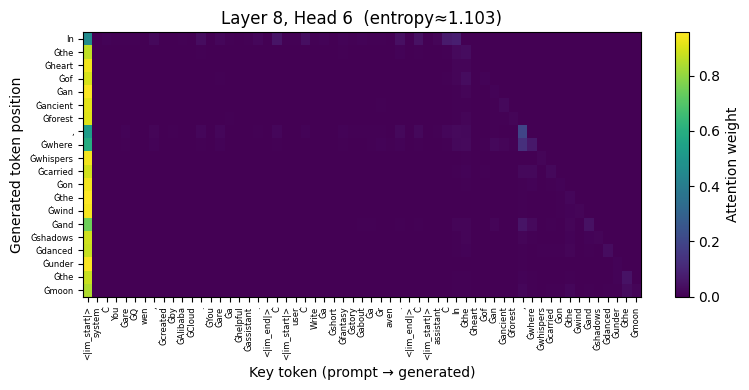

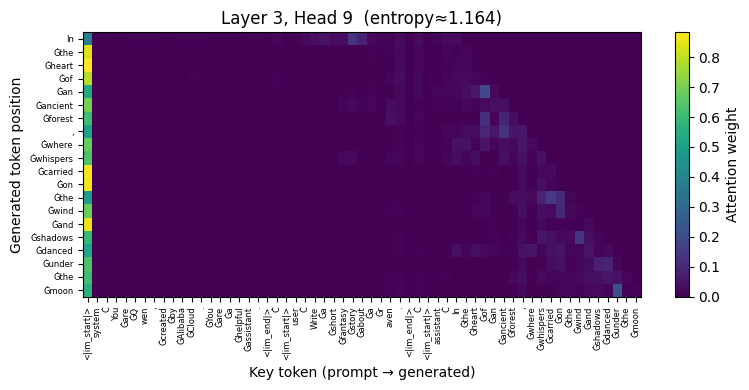

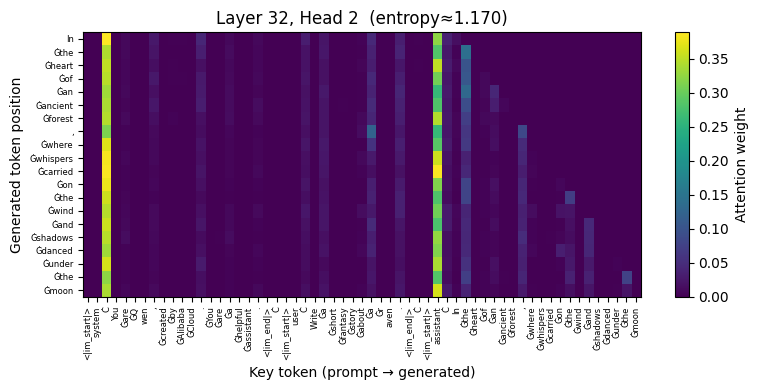

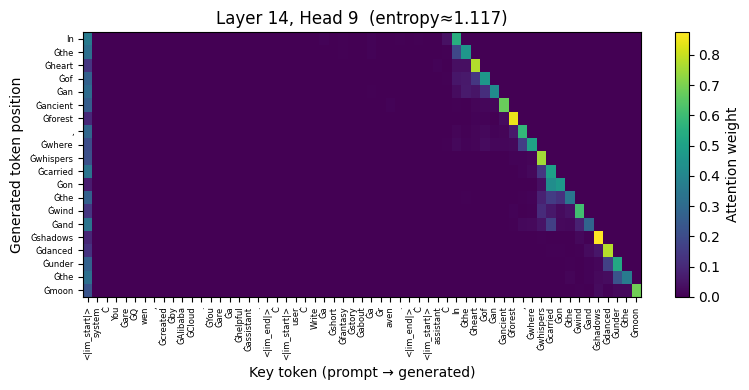

In [ ]:
import torch
import matplotlib.pyplot as plt


heads_to_plot = {}
for layer, head, ent in low_heads:               # iterate low-entropy heads
    heads_to_plot[(layer, head)] = ent
for (layer, head), ent in top5:                   # iterate top-5 heads
    heads_to_plot[(layer, head)] = ent
for layer, head, ent in mid_sample:               # iterate mid-entropy heads
    heads_to_plot[(layer, head)] = ent

selected_heads = list(heads_to_plot.items())
print(f"Selected {len(selected_heads)} heads for visualization")

# Let's choose a different prompt
probe_prompt = "Write a short fantasy story about a raven."

chat_text = tokenizer.apply_chat_template(
    [{"role": "user", "content": probe_prompt}],
    tokenize=False,
    add_generation_prompt=True
)
inputs = tokenizer([chat_text], return_tensors="pt").to(model.device)

gen_out = model.generate(
    **inputs,
    max_new_tokens=20,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    return_dict_in_generate=True,
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id
)

# Extract full token IDs (prompt + generated)
full_ids = gen_out.sequences[0]                         # tensor of shape [prompt_len+gen_len]
tokens_str = tokenizer.convert_ids_to_tokens(full_ids.tolist())
total_len = len(tokens_str)
prompt_len = inputs.input_ids.size(1)
gen_len = total_len - prompt_len

print(f"\nPrompt length = {prompt_len}, Generated length = {gen_len}, Total = {total_len}")

# Completion
full_inputs = {"input_ids": full_ids.unsqueeze(0).to(model.device)}
out_full = model(**full_inputs, output_attentions=True, use_cache=False)           # compute full attention
attn_matrices = out_full.attentions


for (layer_idx, head_idx), ent_val in selected_heads:
    # Extract full [T, T] matrix for this layer/head
    full_mat = attn_matrices[layer_idx][0, head_idx].to(torch.float32).detach().cpu().numpy()        # [T, T]

    # Slice rows corresponding to generated tokens (indices [prompt_len … total_len-1])
    # This yields a submatrix of shape [gen_len, total_len]
    gen_mat = full_mat[prompt_len : total_len, :]

    plt.figure(figsize=(8, 4))
    plt.imshow(gen_mat[::-1], cmap="viridis", origin="lower", aspect="auto")
    plt.colorbar(label="Attention weight")
    plt.title(f"Layer {layer_idx}, Head {head_idx}  (entropy≈{ent_val:.3f})")
    plt.xlabel("Key token (prompt → generated)")
    plt.ylabel("Generated token position")

    # Label x-axis with all tokens (prompt + generated)
    plt.xticks(ticks=list(range(total_len)), labels=tokens_str, rotation=90, fontsize=6)

    # Label y-axis with generated-token strings
    gen_tokens = [tokens_str[i] for i in range(prompt_len, total_len)]
    plt.yticks(ticks=list(range(gen_len)), labels=gen_tokens[::-1], rotation=0, fontsize=6)

    plt.tight_layout()
    plt.show()


Now, you can try to interpret the heads. (But don't expect that all of them will be well-interpretable.)

The low-entropy heads are indeed those who focus on either `<BOS>` or the current token. However, some of the mid-entropy heads also pay consderable attention to `<BOS>`. It's a well-known phenomenon, actually.

Just to note, somethimes sporadic attention to `<BOS>` in heads that usually don't exhibit such behaviour, may be a sign that the LLM is hallucinating. More accurately, such are **intrinsic hallucinations** - situations when an LLM disregards context (previous tokens), attends to `<BOS>` and generates whatever pleases it.

# Part 3. Qwen3-30B-A3B - a Mixture-of-Experts model

**Mixture-of-Experts** (**MoE**) is a mechanism allowing to increase the number of parameters in the FFN blocks of an LLM without damaging inference cost. The idea is to create several copies of the original FFN layers and add a **router** layer that decides to which layers to asign the processing of each token:

<center>
<img src="https://drive.google.com/uc?export=view&id=1dBiZwFRZ5zTTA2nw1TbllgG0JCrqL5e0" width=600 />
</center>

For example, the model [**Qwen3-30B-A3B**](https://huggingface.co/Qwen/Qwen3-30B-A3B) has:

* **30.5B** in total and **3.3B** activated for each token
* **128** "experts" in total
* **8** experts are activated for each token

(All this information is given in the model card on Hugging Face.)

Let's load this model. For that, you'll need at least 40GB GPU memory, which means A100 or better.

**Note**. The original model takes around 60GB GPU memory, but to save space we'll load it in 8-bit **quantization** (that is, all the floating point parameters are stored in reduced, 8-bit precision instead of usual 16-bit). This allows to save about half the space on GPU, but decreases quality. You don't need to think much about it just now; we'll have a separate notebook about quantization in Topic 5.

An important thing, however, is that you still need to have these 60GB on drive, because the model is downloaded in full precision and only loaded to GPU in 8-bit.

**Warning**. Loading the model might take time. If the slider moves slowly, just go grab some coffee.

In [ ]:
!pip install -U -q bitsandbytes

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

model_name = "Qwen/Qwen3-30B-A3B"

# Configure 8-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True,  # Offload some layers to CPU if needed
)

# Load the tokenizer and the model with 8-bit quantization
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True  # Required for Qwen models
)

# Prepare the model input
prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True  # Switches between thinking and non-thinking modes. Default is True.
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# Conduct text completion
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=32768,
    do_sample=True,
    temperature=0.7,
    pad_token_id=tokenizer.eos_token_id
)

output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

# Parsing thinking content
try:
    # rindex finding 151668 (</think>)
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0

thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

print("thinking content:", thinking_content)
print("content:", content)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00002-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00003-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00005-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00001-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00004-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00008-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00007-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00006-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00009-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00010-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00011-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00012-of-00016.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00013-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00014-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00015-of-00016.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00016-of-00016.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/16 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


thinking content: <think>
Okay, the user is asking for a short introduction to large language models. Let me start by defining what they are. I should mention that they're AI systems trained on vast amounts of text data. Maybe explain that they can understand and generate human-like text.

I need to highlight their applications, like answering questions, writing, coding, etc. Also, mention the underlying technology, like deep learning and neural networks. It's important to note that they're based on transformer architectures, which are efficient for processing sequences.

I should also touch on their capabilities, such as multilingual support and contextual understanding. But maybe keep it brief since the user wants a short intro. Avoid too much jargon, but make sure to cover key points. Let me check if I'm missing anything. Oh, maybe mention that they're developed by companies like Google, Meta, and others. Also, their ability to learn from data without explicit programming.

Wait, sh

Let's look at the model's structure:

In [ ]:
model

Qwen3MoeForCausalLM(
  (model): Qwen3MoeModel(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-47): 48 x Qwen3MoeDecoderLayer(
        (self_attn): Qwen3MoeAttention(
          (q_proj): Linear8bitLt(in_features=2048, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear8bitLt(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=2048, bias=False)
          (q_norm): Qwen3MoeRMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3MoeRMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MoeSparseMoeBlock(
          (gate): Linear8bitLt(in_features=2048, out_features=128, bias=False)
          (experts): ModuleList(
            (0-127): 128 x Qwen3MoeMLP(
              (gate_proj): Linear8bitLt(in_features=2048, out_features=768, bias=False)
              (up_proj): Linear8bitLt(in_features=2048, out_features=768, bia

**Note**. In the attention blocks, you can see **RMSNorm** layers with a strange dimension 128: `Qwen3MoeRMSNorm((128,), eps=1e-06)`. Actually, 128 is the dimension of a head, and normalization happens separately across every head.

## LLM parameter calculation

As a useful exercise, let's compute how many parameters there are in different layers and check the total numbers provided by the authors.

Let's see how many parameters do we have in different layers

* **Embedding layer** which basically a dictionary `token:embedding` storing embeddings of dimension **2048** for **151936** tokens (some of them are service or placeholder tokens). This gives $151936 \cdot 2048 = 311,164,928 \approx $ <font color="red">300M parameters</font>
* **48x Transformer blocks**, each having inside:
  *  **Self-attention**, with four learnable matrices:
    * `q_proj` (we called it $W_Q$) of size **2048$\times$4096** (note the order: it's because we have $q = xW_q$), which gives $8,388,608\approx$ <font color="red">8.4M parameters</font>.
    * `k_proj` ($W_K$) and `v_proj` ($W_V$), each of size **2048$\times$512**. This, by the way, means that we have $8 = \frac{4096}{512}$ query heads per each key/value head. Each of these matrices thus has $1,048,576\approx$ <font color="red">1M parameters</font>.
    * `o_proj` ($W_O$) is the output projection matrix of size **4096$\times$2048**, again with approximately <font color="red">8.4M parameters</font>.

    The self-attention layers of all 48 transformer blocks have together $905,969,664\approx$<font color="red">900M parameters</font>. Note that this is just a relatively small part of the total 30B parameter count!


  * **MoE layer** (which is basically a mutated FFN), which has:
    * A **router** which is akin to a linear classifier with 128 ( = number of "experts") classes. It has shape **2048$\times$128** and $262,144\approx$ <font color="red">250K parameters</font>
    * **128x gated MLP**, like we saw earlier in this notebook, each with three matrices. Each "expert" has $3\cdot 2048\cdot 768 = 4,718,592\approx$ <font color="red">4.7M parameters</font> - and that's each expert, with total $\approx$ <font color="red">600M parameters</font>

    If we sum these numbers over all 48 layers, we'll get $\approx$ <font color="red">29B parameters</font>.
    
    So, almost all LLM's parameters are actually in MoE layers. In non-MoE LLMs the FFN parts are smaller, but still they dominate the overall parameter count, and it sounds likely that FFN layers host the LLMs' "memory".

## Analyzing the MoE layer & Pytorch hooks

In this part, we'll take a closer look at MoE's work. We are unlikely to fit a large batch in one GPU and check the balancing - that is how many prompts in a batch are assigned to each "expert", but at least we'll see it in action.

Let's take four simple prompts from different domains and take a look at the experts assigned to each of the tokens. We will make a single transformer pass, as if we predict only one next token.

For that, we'll need to:

* Define a hook function that saves a layer's outputs somewhere
* Register this hook on each of the router layers `model.model.layers[i].mlp.gate`
* Make a single forward pass with `model(**model_inputs, use_cache=False)`

In [ ]:
from collections import defaultdict
from functools import partial
import torch

prompts = [
    "Who wrote Moby Dick?",
    "How much is 12 * 24?",
    "What's your name?",
    "Write 'Hello world!' in Python"
]
texts = [tokenizer.apply_chat_template([{"role":"user","content":p}],
                                       tokenize=False, add_generation_prompt=True,
                                       enable_thinking=True) for p in prompts]
model_inputs = tokenizer(texts, return_tensors="pt", padding=True).to(model.device)
batch_size, total_len = model_inputs.input_ids.shape[:2]


router_outputs = defaultdict(list)
handles = []

# Defining the hook
def capture(module, inp, out, layer_idx):
    out = out.view(batch_size, total_len, -1) # restore [B, T, 128]
    router_outputs[layer_idx].append(out.detach().cpu())

# Registering a hook's instance for every router layer
for idx, layer in enumerate(model.model.layers):
    h = layer.mlp.gate.register_forward_hook(
        partial(capture, layer_idx=idx))
    handles.append(h)

# Making just a single transformer pass
with torch.no_grad():
    _ = model(**model_inputs, use_cache=False)

# Removing handles
for h in handles:
    h.remove()

# A sanity check
print(router_outputs[0][0].shape) # should be torch.Size([4, total_len, 128])

/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


torch.Size([4, 19, 128])


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

model_name = "Qwen/Qwen3-30B-A3B"

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Now let's print tokens vs 8 chosen experts for layer 0:

In [ ]:
import torch
import pandas as pd

detokenized_tokens = [
    [tokenizer.decode([token]) for token in row]
    for row in model_inputs['input_ids'].detach().cpu()
]

layer0_logits = router_outputs[0][0]
batch_size, seq_len, num_experts = layer0_logits.shape

for i in range(batch_size):
    # Extract this prompt’s per-token logits
    token_logits = layer0_logits[i]
    tokens = detokenized_tokens[i]

    # Find top-8 experts per token
    values, indices = torch.topk(token_logits, k=8, dim=-1)

    # Build a DataFrame
    data = {'token': tokens}
    for rank in range(8):
        data[f'{rank+1}']    = indices[:, rank].tolist()

    df = pd.DataFrame(data)

    print(f"\nPrompt {i} — Top-8 experts for each token:\n")
    print(df)



Prompt 0 — Top-8 experts for each token:

            token    1    2    3    4    5    6    7    8
0    <|im_start|>   49   58   19   29   16   70  116  114
1            user   66  105  125   86   24  122   36   95
2              \n  114   16   98   84    1   53  100   26
3             Who    2   50   80   75   21   13   63  115
4           wrote   62  126   69   29    3  111  120  125
5               M   72   50   75   49   78    6   85   32
6             oby   70   89   33    4   28   22   92  111
7            Dick  122   75   33   91   64   82   28   87
8               ?   98   65   99  114   45  102   72   40
9      <|im_end|>   90   32   72   82   95   21   33   62
10             \n   98   16    1   84  114   53  100   26
11   <|im_start|>   94  108  102   66    6   60   99   13
12      assistant   91  105   12  122   77   67   86   82
13             \n   84   16   98    1  114   53   45  100
14  <|endoftext|>   60   53   84  119   68   16    1    9
15  <|endoftext|>   53   84  

We don't have enough data to attribute every expert, but we can already see some interesting patters, for example:

* There are specialized `<|endoftext|>` experts
* Math also seems to attrach its own expert crowd
* All the four prompts start with more or less the same expert team which dissolves as the prompts uncover

# Practice tasks

If you encounter any difficulties or simply want to see our solutions, feel free to check the [Solutions notebook](https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic4/4.2_dissecting_an_llm_solutions.ipynb).

## Task 1. Assessing the artchitecture of **gemma-3-1b-it**

In this task, you'll need to study the architecture of [**gemma-3-1b-it**](https://huggingface.co/google/gemma-3-1b-it) by Google:

- How many layers, attention heads, and query heads per key/value head does it have?
- What is the internal structure of the FFN block?
- How many parameters does the LLM have in self-attention vs in FFN blocks?
- Which type of attention masking (multiplicative or additive) does it use?

## Task 2. Key-value cache

Each time an LLM generates a new token $y_t$, it needs to calculate, at each self-attention layer,

$$(q_tk_1^T)v_1 + (q_tk_2^T)v_2 \ldots + (q_tk_2^T)v_2$$

and for that, you need all the keys $k_i = x_iW_K$ and values $v_i = x_iW_V$, where $x_i$ are inputs for the self-attention layer. Theoretically, this would require recalculating all the $k_i$ and $v_i$ *for every newly generated token* which is a terrible waste of compute.

So, in most situations **keys and values are cached**, and the data structure in which they are stored is known as **KV-cache**.

<center>
<img src="https://drive.google.com/uc?export=view&id=1X4kCfcpAXNAcHrVsGVpsOk6roHL0AOnT" width=600 />
</center>

Of course, caching has its own downsides: the LLM's appetites for additional memory increase linearly as the sequence length grows.

### Two stages of LLM inference

Introduction of KV-cache makes more clear the necessity of distinguising between the following two stages of LLM inference:

1. At the **Cache pre-fill** stage, the prompt is processed and the KV-cache for prompt tokens is populated.
2. At the **Autoregressive generation** stage, new tokens are generated, one by one.

### Your task

In this task, you'll need to update the implementation of Scaled dot product attention layer given below, adding KN-cache support to it. Make sure that both key and value vectors ($k = xW_K$ and $v = xW_V$) are only calculated once for each token.

Assume that during LLM inference, the transformer's `forward` method is called by an external `generate` function, which

* At the **cache pre-fill stage** runs `forward` on the whole prompt
* At the **autoregressive generation stage** only sends the current sequence's last token to `forward`.

You can have in mind the following generation process:

```python
def generate(model, prompt_tokens, max_new_tokens=50, eos_token_id=None):
    """
    Minimalistic generation showing prefill and generation phases.
    
    Args:
        model: Transformer model with KV-cache support
        prompt_tokens: Input prompt tensor (batch_size, prompt_len, d_model)
        max_new_tokens: Maximum number of tokens to generate
        eos_token_id: End-of-sequence token ID
    """
    # Phase 1: Cache pre-fill - processes entire prompt at once
    model.clear_cache()
    output = model(prompt_tokens, is_causal=True, use_cache=True)
    
    # Get last token's output as starting point for generation
    next_token_logits = output[:, -1, :]  # (batch_size, d_model)
    
    generated_tokens = []
    
    # Phase 2: Autoregressive generation - processes one token at a time
    for i in range(max_new_tokens):
        # Sample next token (simplified - just using argmax)
        next_token_id = next_token_logits.argmax(dim=-1, keepdim=True)
        
        # Check for EOS
        # In this implementation, batch generation stops when the longest continuation in a batch is generated
        if eos_token_id is not None and (next_token_id == eos_token_id).all():
            break
        
        # Process single new token using cached K,V
        output = model(next_token_id, use_cache=True)
        
        # Get logits for next token prediction
        next_token_logits = output[:, -1, :]
        
        generated_tokens.append(next_token_id)
    
    return torch.cat(generated_tokens, dim=1)  # (batch_size, num_generated)
```




In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class ScaledDotProductAttention(nn.Module):
    """
    Scaled Dot-Product Attention without KV-cache.

    Based on PyTorch's scaled_dot_product_attention implementation,
    wrapped in a class with linear projections for Q, K, V.
    """

    def __init__(self, d_model, n_heads, dropout_p=0.0):
        """
        Args:
            d_model: Dimension of the model (must be divisible by n_heads)
            n_heads: Number of attention heads
            dropout_p: Dropout probability for attention weights
        """
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # Dimension per head
        self.dropout_p = dropout_p

        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def _scaled_dot_product_attention(self, query, key, value, attn_mask=None,
                                      is_causal=False, scale=None):
        """
        Compute scaled dot-product attention.
        Based on PyTorch's implementation.

        Args:
            query: (batch_size, n_heads, L, d_k)
            key: (batch_size, n_heads, S, d_k)
            value: (batch_size, n_heads, S, d_k)
            attn_mask: Optional mask (batch_size, 1, L, S) or (1, 1, L, S)
            is_causal: If True, applies causal masking
            scale: Optional scaling factor (defaults to 1/sqrt(d_k))

        Returns:
            attention_output: (batch_size, n_heads, L, d_k)
            attention_weights: (batch_size, n_heads, L, S)
        """
        L, S = query.size(-2), key.size(-2)
        scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale

        # Initialize attention bias
        attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)

        # Apply causal mask if requested
        if is_causal:
            temp_mask = torch.ones(L, S, dtype=torch.bool, device=query.device).tril(diagonal=0)
            attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
            attn_bias = attn_bias.to(query.dtype)

        # Apply custom attention mask if provided
        if attn_mask is not None:
            if attn_mask.dtype == torch.bool:
                attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
            else:
                attn_bias = attn_mask + attn_bias

        # Compute attention scores
        attn_weight = query @ key.transpose(-2, -1) * scale_factor
        attn_weight += attn_bias
        attn_weight = torch.softmax(attn_weight, dim=-1)

        # Apply dropout if in training mode
        if self.dropout_p > 0 and self.training:
            attn_weight = F.dropout(attn_weight, p=self.dropout_p)

        # Compute attention output
        attention_output = attn_weight @ value

        return attention_output, attn_weight

    def forward(self, x, attn_mask=None, is_causal=False):
        """
        Forward pass for scaled dot-product attention.

        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
            attn_mask: Optional attention mask. Can be:
                       - Boolean tensor where True = attend, False = mask
                       - Float tensor with additive attention scores
                       Shape: (batch_size, 1, seq_len, seq_len) or (1, 1, seq_len, seq_len)
            is_causal: If True, applies causal masking (attn_mask must be None)

        Returns:
            output: Attention output of shape (batch_size, seq_len, d_model)
            attention_weights: Attention weights of shape (batch_size, n_heads, seq_len, seq_len)
        """
        batch_size, seq_len, _ = x.shape

        # Linear transformations
        Q = self.W_q(x)  # (batch_size, seq_len, d_model)
        K = self.W_k(x)  # (batch_size, seq_len, d_model)
        V = self.W_v(x)  # (batch_size, seq_len, d_model)

        # Reshape for multi-head attention
        # Shape: (batch_size, n_heads, seq_len, d_k)
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        # Compute scaled dot-product attention
        context, attention_weights = self._scaled_dot_product_attention(
            Q, K, V, attn_mask=attn_mask, is_causal=is_causal
        )

        # Concatenate heads and apply output projection
        # First transpose: (batch_size, seq_len, n_heads, d_k)
        # Then reshape: (batch_size, seq_len, d_model)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(context)

        return output, attention_weights

You can use the following code to test your implementation:

In [ ]:
import torch
import torch.testing
import time


def test_kv_cache_correctness(attention_module, d_model=512, n_heads=8, seq_len=20, batch_size=2):
    """Test that cached and non-cached modes produce identical results."""
    print("\n=== Test 1: Correctness - Cached vs Non-cached ===")

    # Create input sequence
    x = torch.randn(batch_size, seq_len, d_model)

    # Method 1: Process entire sequence without cache
    attention_module.clear_cache()
    output_no_cache, weights_no_cache = attention_module(x, is_causal=True, use_cache=False)

    # Method 2: Process sequence token-by-token with cache
    attention_module.clear_cache()
    outputs_cached = []

    for i in range(seq_len):
        token = x[:, i:i+1, :]
        output, _ = attention_module(token, use_cache=True)
        outputs_cached.append(output)

    output_cached = torch.cat(outputs_cached, dim=1)

    # Compare
    torch.testing.assert_close(output_no_cache, output_cached, rtol=1e-5, atol=1e-5)
    print("Outputs match for implementations without and with cache!")
    print(f"  Max difference: {(output_no_cache - output_cached).abs().max().item():.2e}")


def test_kv_cache_incremental(attention_module, d_model=512, n_heads=8, batch_size=2):
    """Test incremental cache building."""
    print("\n=== Test 2: Incremental Cache Building ===")

    attention_module.clear_cache()
    cache_sizes = []

    # Add tokens one by one
    for i in range(10):
        token = torch.randn(batch_size, 1, d_model)
        output, _ = attention_module(token, use_cache=True)
        cache_size = attention_module.get_cache_size()
        cache_sizes.append(cache_size)
        print(f"  Step {i+1}: Added 1 token, cache size = {cache_size}")

    # Verify cache grows linearly
    expected_sizes = list(range(1, 11))
    assert cache_sizes == expected_sizes, f"Cache sizes {cache_sizes} != expected {expected_sizes}"
    print("Cache grows linearly, as expected!")


def test_prefill_vs_generation(attention_module, d_model=512, n_heads=8, batch_size=2):
    """Test prefill phase vs generation phase behavior."""
    print("\n=== Test 3: Prefill vs Generation Phases ===")

    # Prefill: Process 10 tokens at once
    attention_module.clear_cache()
    prompt = torch.randn(batch_size, 10, d_model)
    output_prefill, _ = attention_module(prompt, is_causal=True, use_cache=True)
    cache_after_prefill = attention_module.get_cache_size()
    print(f"  Prefill: Processed 10 tokens, cache size = {cache_after_prefill}")

    # Generation: Add 5 more tokens one by one
    for i in range(5):
        new_token = torch.randn(batch_size, 1, d_model)
        output_gen, weights = attention_module(new_token, use_cache=True)
        print(f"  Generation step {i+1}: cache size = {attention_module.get_cache_size()}, "
              f"attention weights shape = {weights.shape}")

    assert attention_module.get_cache_size() == 15, "Cache should have 15 tokens total"
    print("Prefill and generation phases seem to work correctly!")


def test_attention_pattern(attention_module, d_model=512, n_heads=8, batch_size=1):
    """Visualize attention patterns to verify causality."""
    print("\n=== Test 4: Attention Pattern Visualization ===")

    attention_module.clear_cache()
    seq_len = 5
    x = torch.randn(batch_size, seq_len, d_model)

    # Get attention weights
    _, weights = attention_module(x, is_causal=True, use_cache=False)

    # Show attention pattern for first head
    attn_pattern = weights[0, 0, :, :].detach()

    # Verify causality
    for i in range(seq_len):
        for j in range(i+1, seq_len):
            assert attn_pattern[i, j] < 1e-5, f"Token {i} shouldn't attend to future token {j}"
    print("Causal masking verified!")


def test_performance_speedup(AttentionClass, d_model=512, n_heads=8, batch_size=2):
    """Measure actual speedup from KV-cache."""
    print("\n=== Test 5: Performance Speedup ===")

    # Create two instances to avoid cache interference
    attn_no_cache = AttentionClass(d_model, n_heads)
    attn_with_cache = AttentionClass(d_model, n_heads)

    prompt_len = 100
    gen_len = 50

    # Warm up
    x = torch.randn(batch_size, 10, d_model)
    attn_no_cache(x)
    attn_with_cache(x)

    # Test without cache
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start = time.time()

    full_seq = torch.randn(batch_size, prompt_len + gen_len, d_model)
    for i in range(prompt_len, prompt_len + gen_len):
        seq_so_far = full_seq[:, :i+1, :]
        _ = attn_no_cache(seq_so_far, is_causal=True, use_cache=False)

    time_no_cache = time.time() - start

    # Test with cache
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start = time.time()

    # Prefill
    prompt = full_seq[:, :prompt_len, :]
    _ = attn_with_cache(prompt, is_causal=True, use_cache=True)

    # Generation
    for i in range(gen_len):
        new_token = full_seq[:, prompt_len + i:prompt_len + i + 1, :]
        _ = attn_with_cache(new_token, use_cache=True)

    time_with_cache = time.time() - start

    speedup = time_no_cache / time_with_cache
    print(f"  Without cache: {time_no_cache:.3f}s")
    print(f"  With cache: {time_with_cache:.3f}s")
    print(f"  Speedup: {speedup:.1f}x")


def test_batch_consistency(attention_module, d_model=512, n_heads=8):
    """Test that different batch sizes work correctly."""
    print("\n=== Test 6: Batch Size Handling ===")

    # Start with batch size 2
    attention_module.clear_cache()
    x1 = torch.randn(2, 5, d_model)
    out1, _ = attention_module(x1, use_cache=True)

    # Try to process with different batch size (should handle gracefully)
    try:
        x2 = torch.randn(3, 1, d_model)
        out2, _ = attention_module(x2, use_cache=True)
        print("Should not accept different batch sizes with existing cache")
    except (RuntimeError, AssertionError):
        print("Correctly prevents batch size mismatch")

    # Clear and try again
    attention_module.clear_cache()
    out2, _ = attention_module(x2, use_cache=True)
    print("Works with new batch size after clearing cache")


# Run all tests
if __name__ == "__main__":
    print("Testing KV-Cache Implementation")
    print("=" * 50)

    # Create attention module
    attention = ScaledDotProductAttentionWithCache(d_model=512, n_heads=8)
    attention.eval()  # Disable dropout

    # Run tests
    test_kv_cache_correctness(attention)
    test_kv_cache_incremental(attention)
    test_prefill_vs_generation(attention)
    test_attention_pattern(attention)
    test_performance_speedup(ScaledDotProductAttentionWithCache)
    test_batch_consistency(attention)

    print("\n" + "=" * 50)
    print("All tests completed!")

Testing KV-Cache Implementation

=== Test 1: Correctness - Cached vs Non-cached ===
Outputs match for implementations without and with cache!
  Max difference: 5.66e-07

=== Test 2: Incremental Cache Building ===
  Step 1: Added 1 token, cache size = 1
  Step 2: Added 1 token, cache size = 2
  Step 3: Added 1 token, cache size = 3
  Step 4: Added 1 token, cache size = 4
  Step 5: Added 1 token, cache size = 5
  Step 6: Added 1 token, cache size = 6
  Step 7: Added 1 token, cache size = 7
  Step 8: Added 1 token, cache size = 8
  Step 9: Added 1 token, cache size = 9
  Step 10: Added 1 token, cache size = 10
Cache grows linearly, as expected!

=== Test 3: Prefill vs Generation Phases ===
  Prefill: Processed 10 tokens, cache size = 10
  Generation step 1: cache size = 11, attention weights shape = torch.Size([2, 8, 1, 11])
  Generation step 2: cache size = 12, attention weights shape = torch.Size([2, 8, 1, 12])
  Generation step 3: cache size = 13, attention weights shape = torch.Size([

In [ ]:
# <YOUR CODE HERE>

## Task 3. Interpreting LLMs with LogitLens

Logit Lens is an interpretation technique introduced in [this post](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens). The idea is the following. Imagine that we predict the continuation of a phrase "IPhone was developed by". We naturally expect to see "Apple", but we're also curious to see the "thought process" of an LLM, so we **feed outputs of intermediate layers (intermediate transformer blocks) to the classification head** to see *what would an LLM output if we cut its "thought process" short in the middle of it*. The general trend, as one moves from earlier to later layers, is
- "nonsense / not interpretable" (sometimes, in very early layers) -->
  - "shallow guesses" (words that are the right part of speech / register / etc) -->
- "better guesses" near the end.
However, it's not always like that, of course.

The author of the Logit Lens also created visualization tools and published a [jupyter notebook demo](https://colab.research.google.com/drive/1MjdfK2srcerLrAJDRaJQKO0sUiZ-hQtA?usp=sharing) with cool pictures, but in this task you'll need to reproduce the Logit Lens technique on your own.

**Your task**. Write a function

```
logit_lens(model, input_sentence, top_k)
```

that for each transformer block returns a dictionary

```
{
    'top_tokens' : [
        sorted list of top_k tokens,
        from most probable to least probable,
        according to the classification head
        ],
    'top_token_logits' : [logits of these tokens]
}
```

You can either use Pytorch hooks or just `model(**encoded_input, output_hidden_states=True)`.


Here is how it should work:

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

And here comes the logit lens:

In [ ]:
import numpy as np

def logit_lens(model, input_sentence, top_k=5):
    # Tokenize the inputs: this turns text into a list of token indices
    input_ids = tokenizer(input_sentence, return_tensors='pt').to(device)

    # This runs the forward pass, calculating all the hidden states thanks to the output_hidden_states=True
    model_output = model(**input_ids,  output_hidden_states=True)
    hidden_states = model_output.hidden_states

    # This is the LLM's final layer: it takes transformer's output (one vector)
    # and for each possible token on the vocabulary predicts its probability
    model_head = model.lm_head

    result = []

    for layer in hidden_states:

        """
        YOUR TASK HERE IS AS FOLLOWS:

        The layer's output consists of a number of hidden state vectors: one vector for each input token
        You need to:
        1. take the last of the outputs and to apply the lm_head to it
        2. find k tokens with top probabilities. The function torch.topk might help
            Just check what torch.topk outputs
        3. return:
        output = {
            "top_tokens": the array of top tokens. Don't forget to decode them with tokenizer.decode
            "top_token_logits": the array of their logits. Don't forget to detach the tensor and to convert it to numpy!
        }
        Note that we need to decode
        """
        # <YOUR CODE HERE>
        result.append(output)
    return result


In [ ]:
result = logit_lens(model, "IPhone was developed by", top_k=5)

In [ ]:
result[-2:]

[{'top_tokens': [' ', ',', ' a', ' (', '\n'],
  'top_token_logits': array([77.5 , 66.  , 64.5 , 60.  , 58.75], dtype=float32)},
 {'top_tokens': [' Microsoft', ' Apple', ' a', ' the', ' an'],
  'top_token_logits': array([18.25 , 18.125, 16.75 , 16.5  , 14.875], dtype=float32)}]

As you see, "Apple" appears as the most probable token in the last two layers.

Now, let's use Logit Lens to investigate how transformers deal with redefinition.

We'll use Logit Lens on the sentence

```
"In this text the word IPhone means Windows operating system. IPhone was developed by"
```

Run the following cell and look at the most probable tokens for all layers. A good LLM knows that IPhone was developed by Apple through *memorization*. However, *in-context learning* will press it to output Microsoft. Check in which layers the most probable token is Microsoft and in which it is Apple.

In [ ]:
result = logit_lens(model, "In this text the word IPhone means Windows operating system. IPhone was developed by", top_k=5)
result

Try more prompts and other models. Have fun trying to interpret whatever is inside LLMs :)

In [ ]:
# <YOUR CODE HERE>

## Task 4. Steering LLM generation via Activation Interventions

Imagine you want to change the style of your LLM's output. We already know how to do this using clever prompting and few-shot examples - but there's another approach: directly modifying the model's internal activations.

The method you'll explore in this task was, to the best of our knowledge, first introduced in [this post at LessWrong](https://www.lesswrong.com/posts/5spBue2z2tw4JuDCx/steering-gpt-2-xl-by-adding-an-activation-vector). Conceptually, however, it draws inspiration from techniques used in image editing via latent space manipulation.

The core idea is that some abstract concepts - such as a particular writing style - may be represented as directions in the latent spaces of one of the model's hidden layers. If you can identify the right layer and find the appropriate direction vector $d$, then you can steer the model's output by shifting a hidden state $x$ along this vector:

* $x \mapsto x + d$ reinforces the concept.

* $x \mapsto x - d$ suppresses the concept, or enhances its opposite.

For example, if $d =$ (poetic style - bureaucratic style), then adding $d$ to the hidden state may make the output more poetic, while subtracting it may push the model toward bureaucratic language.

But where to get the vector $d$? In the most basic case, it can be obtained from just two prompts:

* <font color="red">Negative prompt</font> embodying the opposite concept and
* <font color="blue">Positive prompt</font> epitomizing the concept we are interested it.

Now, if we want to manupilate the outputs of $L$-th layer, we do the following:

1. We find $\color{red}{x_-}$ and $\color{blue}{x_+}$ - outputs of the $L$-th layer for the *final* tokens of <font color="red">Negative prompt</font> and <font color="blue">Positive prompt</font>
2. We take $d = \color{blue}{x_+} - \color{red}{x_-}$ as the concept's direction.

Why this might work? The final token of a prompt receives attention from all the previous tokens, so at aggregates in a sense whatever's happening in the prompt at the $L$-th layer. Now, if the prompts are expressive enought, the difference might $d$ might capture the concept gap.

**Your task** is to complete the `LLMSteering` class code below, implementing this simple LLM steering technique.

Some notes about the implementation:

* You'll need to use **Pytorch hooks** for that.
* The `strength` parameter is the coefficient $\mathbf{s}$ in $d = \mathbf{s}(x_+ - x_-)$.
* The **model** is initialized externally and can be used in many `LLMSteering` instances. And rightfully so - if you initialize a new model in each `LLMSteering`, you'll soon run out of GPU memory.
* Don't forget that crashed hooks don't get removed by `hook.remove()`, only by `layer._forward_hooks.clear()`. Since you don't want to corrupt the model, we suggest having some emergency measures to get rid of failed hooks.

When you finish with the implementation, experiment with steering:

1. Try several prompt pairs for different concepts or styles: literary vs bureaucratic, polite vs angry etc.
2. Try larger and smaller `strength`
3. Try different layers; find the best one for your concept.

  You may try steering at several layers at once, but this will unlikely be a good idea: the effects at several layers will interfere unpredictably.

4. (Optional) You can try steering for two concepts at once, computing directions $d_1$ and $d_2$ for them independently and then adding them to the hidden state. However, simple $x\mapsto x + d_1 + d_2$ might work poorly. It's better to use [SLERP](https://en.wikipedia.org/wiki/Slerp) for that.

  And, of course, you'll need to update the class.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch, functools


model_name = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Here's the template:

In [ ]:
import torch
import functools
from typing import Optional

class LLMSteering:
    """
    Simple activation steering for LLMs
    """

    def __init__(self, model, tokenizer):
        """
        Initialize the steering controller.

        Args:
            model: The LLM
            tokenizer: The tokenizer
        """
        self.model = model
        self.tokenizer = tokenizer
        self.device = model.device

        # Current steering state
        self.hook = None
        self.current_layer = None

    def _get_hidden_vector(self, text: str, layer: int) -> torch.Tensor:
        """Get the last token's hidden state from specified layer."""
        # <YOUR CODE HERE>
        return   # [hidden_dim]

    def _steering_hook(self, steering_vector: torch.Tensor, module, inp, out):
        """
        Forward hook that adds steering vector to hidden states.

        PyTorch forward hook signature: hook(module, input, output) -> None or modified output
        """
        # <YOUR CODE HERE>

    def set_steering(self, positive_prompt: str, negative_prompt: str, layer: int, strength: float = 1.0):
        """
        Set up steering with given prompts.

        Args:
            positive_prompt: Target behavior prompt
            negative_prompt: Avoid behavior prompt
            layer: Layer to apply steering (0-indexed)
            strength: Multiplier for steering strength
        """
        # <YOUR CODE HERE>
        # Don't forget to remove the existing hook

    def remove_steering(self):
        """Removes steering hook"""
        if self.hook is not None:
            self.hook.remove()
            self.hook = None
            self.current_layer = None

    def force_clear_all_hooks(self):
        """Clears the hook"""
        if self.current_layer is not None:
            self.model.model.layers[self.current_layer]._forward_hooks.clear()
            print("Cleared hooks")

        self.hook = None
        self.current_layer = None

    def generate(self, prompt: str, max_new_tokens: int = 50, **kwargs) -> str:
        """Generate text with current steering settings."""

        # <YOUR CODE HERE>

    def __del__(self):
        """Cleanup when object is destroyed."""
        self.remove_steering()

